# Code Demo

#### - **Date**: 6 April 2023

#### - **Authors**: Austin Coursey and Cameron Baird

#### - **Description**: This notebook provides a demonstration of our final project for DS 5899 (Transformers in Theory and Practice) for the Spring 2023 semester.

In [19]:
import torch.nn as nn
import torch
from lstm import get_audio_paths
import matplotlib.pyplot as plt
import torchaudio
import IPython.display as ipd
import torch.nn.functional as F

-----

### 1. Define model architectures for (1) an LSTM and (2) a Transformer.

In [2]:
class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.length = config['length']
        self.lstm = nn.LSTM(input_size=1, hidden_size=config['hidden_size'], batch_first=True, bidirectional=False)
        self.classification_head = nn.Linear(self.length*config['hidden_size'], 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.reshape_batch(x)
        z = self.lstm(x)[0]
        z = torch.flatten(z, 1)
        z = self.classification_head(z)
        return self.sigmoid(z).squeeze(1)
    
    def reshape_batch(self, data):
        return data.unsqueeze(2)
    
class AudioTransformer(nn.Module):
    def __init__(self):
        super(AudioTransformer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.fix1 = nn.Flatten()
        self.fix2 = nn.Linear(511936, 512)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=4, dim_feedforward=256)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.fc0 = nn.Linear(512, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x)
        x = self.conv2(x); x = self.bn2(x); x = self.relu(x)
        x = self.conv3(x); x = self.bn3(x); x = self.relu(x)
        x = self.fix1(x)
        x = self.fix2(x)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x.squeeze(1))
    
class DataConfig:
    sample_rate=16000 # fixed at 16k in for-norm partition
    lstm_duration=2
    tran_duration=4 # seconds
    
# loading models
lstm = LSTM({'length': DataConfig.sample_rate*DataConfig.lstm_duration,'hidden_size': 64})
tran = AudioTransformer()

In [3]:
num_params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
print(f"Number of parameters in LSTM = {num_params}")
lstm

Number of parameters in LSTM = 2065153


LSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (classification_head): Linear(in_features=2048000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [4]:
num_params = sum(p.numel() for p in tran.parameters() if p.requires_grad)
print(f"Number of parameters in Transformer = {num_params}")
tran

Number of parameters in Transformer = 268732673


AudioTransformer(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(2,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fix1): Flatten(start_dim=1, end_dim=-1)
  (fix2): Linear(in_features=511936, out_features=512, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (

-------

### 2. Load, visualize, and listen to audio files.

In [6]:
def plot_waveform(waveform):
    waveform = waveform.numpy()
    num_frames = len(waveform)
    time_axis = torch.arange(0, num_frames) / DataConfig.sample_rate
    plt.figure(figsize=(5, 3))
    plt.plot(time_axis, waveform, linewidth=1)
    plt.grid(True)
    plt.title(f"Audio Example")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show(block=False)
    
paths = get_audio_paths()

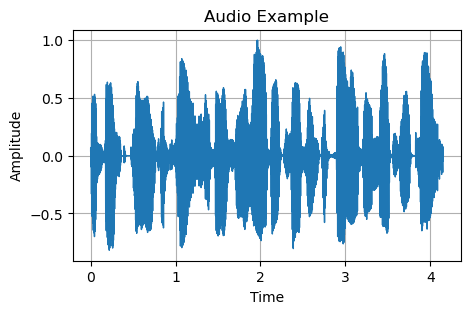

In [14]:
audio1, _ = torchaudio.load(paths[0])
plot_waveform(audio1[0])
ipd.Audio(paths[0])

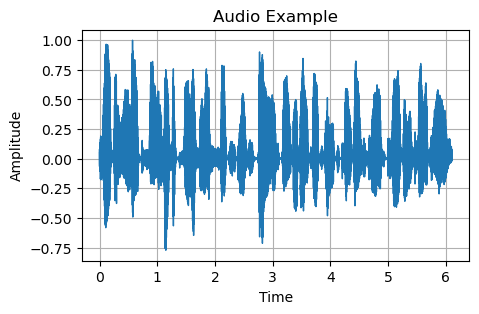

In [15]:
audio2, _ = torchaudio.load(paths[1])
plot_waveform(audio2[0])
ipd.Audio(paths[1])

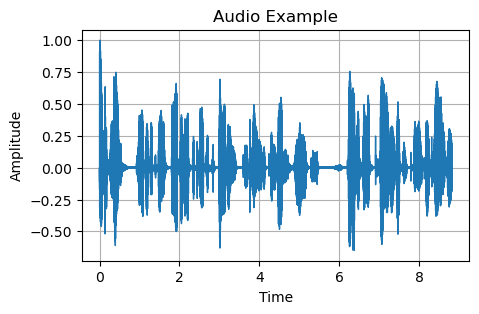

In [16]:
audio3, _ = torchaudio.load(paths[2])
plot_waveform(audio3[0])
ipd.Audio(paths[2])

------
### 3. Load the pre-trained model weights and run inference on our examples.

In [25]:
# load a model from a path to a .pt checkpoint
def load_model(file_path, model_type="lstm"):
    checkpoint = torch.load(file_path)
    model = None
    if model_type == "lstm": model = LSTM({'length': DataConfig.sample_rate*DataConfig.lstm_duration,'hidden_size': 64})
    else: model = AudioTransformer()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

checkpoint_paths = [
    # LSTM (100,75,50,25)
    "./checkpoints/2023-04-05_13-13-56_lstm_1.0_batch16_duration2/model_epoch8_loss0.21875886619091034.pt",
    "./checkpoints/2023-04-05_14-38-35_lstm_0.75_batch16_duration2/model_epoch9_loss0.22048184275627136.pt",
    "./checkpoints/2023-04-05_15-27-58_lstm_0.5_batch16_duration2/model_epoch9_loss0.23512201011180878.pt",
    "./checkpoints/2023-04-05_12-52-35_lstm_0.25_batch16_duration2/model_epoch9_loss0.36030691862106323.pt",
    
    # Transformer (100,75,50,25)
    "./checkpoints/2023-04-04_14-36-00_transformerCNN_1.0_batch512_duration4/model_epoch24_loss0.01282498799264431.pt",
    "./checkpoints/2023-04-04_16-08-15_transformerCNN_0.75_batch512_duration4/model_epoch24_loss0.025699520483613014.pt",
    "./checkpoints/2023-04-05_16-16-08_transformerCNN_0.5_batch512_duration4/model_epoch14_loss0.078721784055233.pt",
    "./checkpoints/2023-04-05_12-42-27_transformerCNN_0.25_batch512_duration4/model_epoch14_loss0.07888667285442352.pt",
]

models = []
for i in range(len(checkpoint_paths)):
    if i <= 3: models.append(load_model(checkpoint_paths[i]))
    else: models.append(load_model(checkpoint_paths[i], model_type="transformer"))

In [29]:
# prepare the audio files to be fed into the network
# this is a bit weird, because of the batch sizes and non-DataLoader preprocessing
def prep_audio(audio_tensor, model_type="lstm"): # feed it into the network
    num_samples = 16000*DataConfig.lstm_duration
    if "lstm" != model_type: num_samples = 16000*DataConfig.tran_duration
    if audio_tensor.shape[0] > 1:
        audio_tensor = torch.mean(audio_tensor, axis=0, keepdim=True)
    if audio_tensor.shape[1] > num_samples:
        audio_tensor = audio_tensor[:, :num_samples]
    if audio_tensor.shape[1] < num_samples:
        num_missing_samples = num_samples - audio_tensor.shape[1]
        audio_tensor = F.pad(audio_tensor, (0, num_missing_samples))
    return audio_tensor

audio1_lstm = prep_audio(audio1); audio1_tran = torch.unsqueeze(prep_audio(audio1, model_type="transformer"), 1)
audio2_lstm = prep_audio(audio2); audio2_tran = torch.unsqueeze(prep_audio(audio2, model_type="transformer"), 1)
audio3_lstm = prep_audio(audio3); audio3_tran = torch.unsqueeze(prep_audio(audio3, model_type="transformer"), 1)

# audio 1 predictions
audio1_preds = []
for i, model in enumerate(models):
    if i <= 3: audio1_preds.append(model(audio1_lstm).item())
    else: audio1_preds.append(model(audio1_tran).item())

# audio 2 predictions
audio2_preds = []
for i, model in enumerate(models):
    if i <= 3: audio2_preds.append(model(audio2_lstm).item())
    else: audio2_preds.append(model(audio2_tran).item())

# audio 3 predictions
audio3_preds = []
for i, model in enumerate(models):
    if i <= 3: audio3_preds.append(model(audio3_lstm).item())
    else: audio3_preds.append(model(audio3_tran).item())

In [30]:
print(f"Predictions on Audio Sample 1: {audio1_preds}\n\n")
print(f"Predictions on Audio Sample 2: {audio2_preds}\n\n")
print(f"Predictions on Audio Sample 3: {audio3_preds}\n\n")

Predictions on Audio Sample 1: [0.09712357074022293, 0.07292048633098602, 0.006673926953226328, 0.0023834286257624626, 3.369715955159336e-07, 5.012631731915462e-08, 1.609807623026427e-05, 0.006902412511408329]


Predictions on Audio Sample 2: [0.9826098680496216, 0.9689390063285828, 0.9462137818336487, 0.9644734263420105, 0.9965213537216187, 0.98659747838974, 0.708050549030304, 0.12304263561964035]


Predictions on Audio Sample 3: [0.0006788746686652303, 0.0021373690105974674, 0.005637015216052532, 0.03988732025027275, 1.4814125961493119e-06, 8.620800073799728e-09, 0.0002382157981628552, 0.0026423188392072916]


